In [1]:
from SRCNN_different_specs import RunSRCNN, SRCNN
from custom_image_dataset import CustomImageDataset
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch
from torch import nn
import image_patches
import numpy as np

In [2]:
import random

# Seed for reproducibility
seed = 42  # You can use any seed value

# Set seed for PyTorch
torch.manual_seed(seed)

# Set seed for NumPy
np.random.seed(seed)

# Set seed for Python's random module
random.seed(seed)

In [3]:
TRAIN_DATASET_NAME = "./datasets/TRAIN_Flick2k_DIV2K/"
VALIDATION_DATASET_NAME = "./datasets/VALIDATION_Flickr2K_DIV2K/"
# TRAIN_DATASET_NAME = "../datasets/set14/"
# VALIDATION_DATASET_NAME = "../datasets/Set5/"
PATCH_SIZE = 33

SCALE_FACTOR = 4

EPOCHS = 150

PATCHES_PER_IMAGE_TRAIN = 80 #####
# PATCHES_PER_IMAGE_TRAIN = 10
PATCHES_PER_IMAGE_VALIDATION = 80 #####
# PATCHES_PER_IMAGE_VALIDATION = 3 
TRAIN_DATA_PATH = f"{TRAIN_DATASET_NAME}_{PATCH_SIZE}_{PATCH_SIZE}_number={PATCHES_PER_IMAGE_TRAIN}"
VALIDATION_DATA_PATH =  f"{VALIDATION_DATASET_NAME}_{PATCH_SIZE}_{PATCH_SIZE}_number={PATCHES_PER_IMAGE_VALIDATION}"
print('TRAIN_DATA_PATH =', TRAIN_DATA_PATH)
print('VALIDATION_DATA_PATH =', VALIDATION_DATA_PATH)

TRAIN_DATA_PATH = ./datasets/TRAIN_Flick2k_DIV2K/_33_33_number=80
VALIDATION_DATA_PATH = ./datasets/VALIDATION_Flickr2K_DIV2K/_33_33_number=80


In [4]:
# image_patches.create_valid_image_patches(f"{TRAIN_DATASET_NAME}", (PATCH_SIZE, PATCH_SIZE, 3), TRAIN_DATA_PATH, PATCHES_PER_IMAGE_TRAIN)
# image_patches.create_valid_image_patches(f"{VALIDATION_DATASET_NAME}", (PATCH_SIZE, PATCH_SIZE, 3), VALIDATION_DATA_PATH, PATCHES_PER_IMAGE_VALIDATION)

In [5]:
%%time
transform_x = transforms.Compose([
    transforms.Resize((PATCH_SIZE // SCALE_FACTOR, PATCH_SIZE // SCALE_FACTOR), interpolation=Image.BICUBIC),
    transforms.Resize((PATCH_SIZE, PATCH_SIZE), interpolation=Image.BICUBIC)
    # transforms.Resize((11, 11), interpolation=Image.BICUBIC),
    # transforms.Resize((33, 33), interpolation=Image.BICUBIC)
])

transform_y = transforms.Compose([
    transforms.CenterCrop((PATCH_SIZE, PATCH_SIZE))
])

# Set up the data loaders
train_data_set = CustomImageDataset(
    img_dir=TRAIN_DATA_PATH, transform=transform_x, target_transform=transform_y, tensor_size=PATCH_SIZE)
validation_data_set = CustomImageDataset(
    img_dir=VALIDATION_DATA_PATH, transform=transform_x, target_transform=transform_y, tensor_size=PATCH_SIZE)

# Report split sizes
print('Training set has {} instances'.format(len(train_data_set)))
print('Validation set has {} instances'.format(len(validation_data_set)))

Creating Dataset based on folder: ./datasets/TRAIN_Flick2k_DIV2K/_33_33_number=80


100%|██████████| 2920/2920 [00:12<00:00, 240.14it/s]


Creating Dataset based on folder: ./datasets/TRAIN_Flick2k_DIV2K/_33_33_number=80
Creating Dataset based on folder: ./datasets/VALIDATION_Flickr2K_DIV2K/_33_33_number=80


100%|██████████| 630/630 [00:02<00:00, 240.65it/s]


Creating Dataset based on folder: ./datasets/VALIDATION_Flickr2K_DIV2K/_33_33_number=80
Training set has 97785 instances
Validation set has 21091 instances
CPU times: user 14.6 s, sys: 3.19 s, total: 17.8 s
Wall time: 17.8 s


In [6]:
%%time

# https://towardsdatascience.com/7-tips-for-squeezing-maximum-performance-from-pytorch-ca4a40951259
pin_memory = False
batch_size = round(1.5*(2**12))

train_dataloader = DataLoader(train_data_set, batch_size=batch_size, shuffle=True, pin_memory=pin_memory) # TODO: aumentar batch_size p/ 2^12
validation_dataloader = DataLoader(validation_data_set, batch_size=batch_size, pin_memory=pin_memory)

CPU times: user 1.32 s, sys: 389 ms, total: 1.71 s
Wall time: 1.7 s


In [7]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# lr = 1e-3

# model_f2_5 = SRCNN(f2=5).to(device)
# optimizer_f2_5 = torch.optim.Adam(model_f2_5.parameters(), lr=lr)
# scheduler_f2_5 = torch.optim.lr_scheduler.LinearLR(
#     optimizer_f2_5,
#     start_factor=1.0,
#     end_factor=0.01,
#     total_iters=60)

# model_f2_1 = SRCNN(f2=1).to(device)
# optimizer_f2_1 = torch.optim.Adam(model_f2_1.parameters(), lr=lr)
# scheduler_f2_1 = torch.optim.lr_scheduler.LinearLR(
#     optimizer_f2_1,
#     start_factor=1.0,
#     end_factor=0.01,
#     total_iters=60)


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 1e-3

model = SRCNN(f2=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer,
    start_factor=1.0,
    end_factor=0.01,
    total_iters=60)

model_vgg = SRCNN(f2=5).to(device)
optimizer_vgg = torch.optim.Adam(model_vgg.parameters(), lr=lr)
scheduler_vgg = torch.optim.lr_scheduler.LinearLR(
    optimizer_vgg,
    start_factor=1.0,
    end_factor=0.01,
    total_iters=60)


In [9]:
run_srcnn = RunSRCNN()

In [10]:
%%time

run_srcnn.train_with_vgg(
    model=model_vgg,
    train_dataloader=train_dataloader,
    validation_dataloader=validation_dataloader,
    optimizer=optimizer_vgg,
    epochs=EPOCHS,
    scheduler=scheduler_vgg,
    show_prints=False,
    vgg_loss_weight=0.0
)

/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 0
-------------------------------


/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()`


Epoch 1
-------------------------------

Epoch 2
-------------------------------

Epoch 3
-------------------------------

Epoch 4
-------------------------------

Epoch 5
-------------------------------

Epoch 6
-------------------------------

Epoch 7
-------------------------------

Epoch 8
-------------------------------

Epoch 9
-------------------------------

Epoch 10
-------------------------------

Epoch 11
-------------------------------

Epoch 12
-------------------------------

Epoch 13
-------------------------------

Epoch 14
-------------------------------

Epoch 15
-------------------------------

Epoch 16
-------------------------------

Epoch 17
-------------------------------

Epoch 18
-------------------------------

Epoch 19
-------------------------------

Epoch 20
-------------------------------

Epoch 21
-------------------------------

Epoch 22
-------------------------------

Epoch 23
-------------------------------

Epoch 24
-------------------------------



In [11]:
run_srcnn.save_model_df('./results/srcnn-tecgraf/dataframes/model_f2_5_vgg.csv')
run_srcnn.save_model_weights(model_vgg, './results/srcnn-tecgraf/trained_weights/model_f2_5_vgg.pth')

In [ ]:
# %%time

# run_srcnn.train(
#     model=model,
#     train_dataloader=train_dataloader,
#     validation_dataloader=validation_dataloader,
#     optimizer=optimizer,
#     epochs=EPOCHS,
#     scheduler=scheduler,
#     loss_fn=nn.MSELoss(),
#     show_prints=False
# )

In [ ]:
# run_srcnn.save_model_df('./results/srcnn-tecgraf/dataframes/model_f2_5_vgg.csv')
# run_srcnn.save_model_weights(model_vgg, './results/srcnn-tecgraf/trained_weights/model_f2_5_vgg.pth')

In [12]:
path = f"./datasets/BSDS100/"
# path = f"{DATASET_ROOT}/Set14"
from model_runner import ModelRunner
model_runner = ModelRunner()
model_runner.compare_models([
                              # {"name": "model", "model": model, "scale": 4}, 
                              {"name": "model_vgg", "model": model_vgg, "scale": 4},
                          ],
                            path, 4)


0it [00:00, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:61: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `P

,PSNR,SSIM
model,15.326991,0.485356
model_vgg,17.218700,0.477619
Bicubic,23.045410,0.632868


/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the val

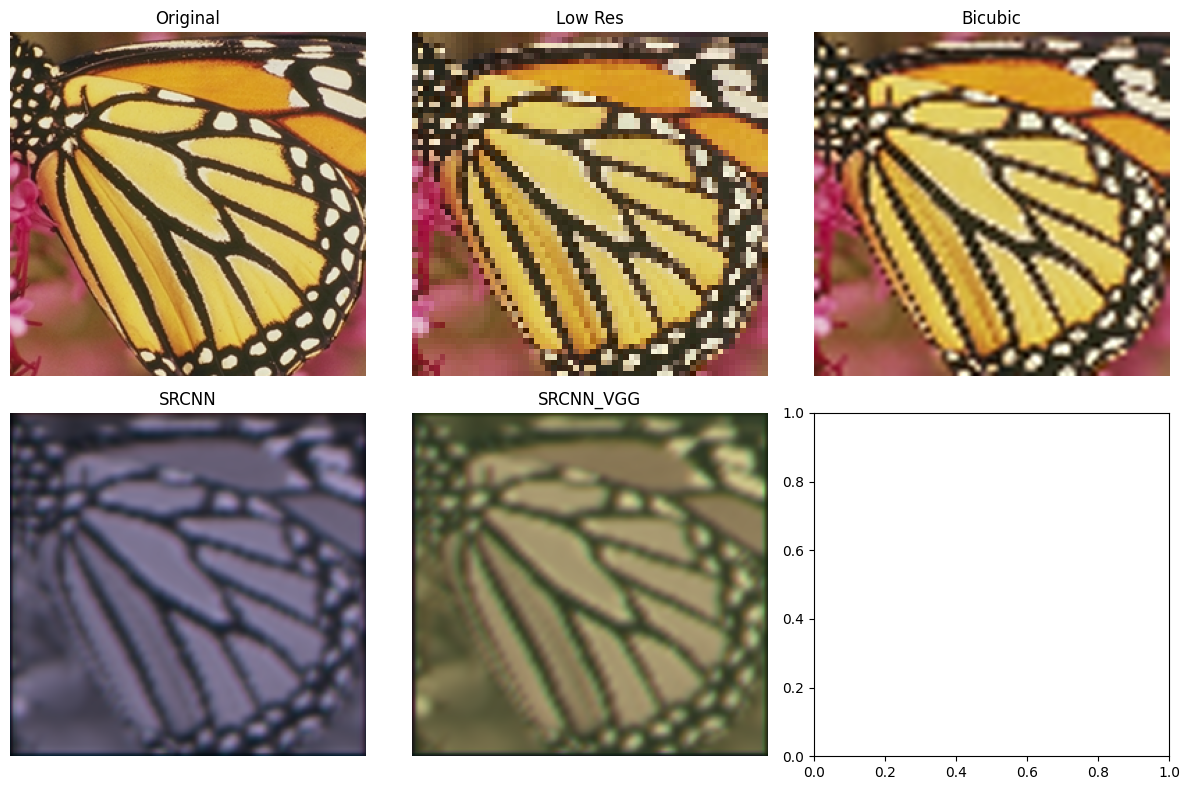

In [13]:
IMAGE_EXAMPLE = "./datasets/Set5/butterfly.png"

from image_helper import ImageHelper
image_helper = ImageHelper()

image_helper.show_tensors_custom_grid(
    tensors = [
        {
            "label": "Original",
            "tensor": image_helper.image_to_tensor(IMAGE_EXAMPLE),
        },
        {
            "label": "Low Res",
            "tensor": image_helper.downsample_image_as_tensor(
                IMAGE_EXAMPLE, 4, interpolation=Image.BICUBIC,
            ),
        },
        {
            "label": "Bicubic",
            "tensor": image_helper.downsample_and_upsample_image_as_tensor(
                IMAGE_EXAMPLE, 4
            ),
        },
        {
            "label": "SRCNN",
            "tensor": image_helper.apply_model_to_image(
                model,
                IMAGE_EXAMPLE,
                4
            )
        },
        {
            "label": "SRCNN_VGG",
            "tensor": image_helper.apply_model_to_image(
                model_vgg,
                IMAGE_EXAMPLE,
                4
            )
        },
    ],
    rows=2,
    cols=3
)

In [9]:
# run_srcnn.save_model_df('./results/srcnn-tecgraf/dataframes/model_f2_1.csv')
# run_srcnn.save_model_weights(model_f2_1, './results/srcnn-tecgraf/trained_weights/model_f2_1.pth')

In [10]:
%%time

run_srcnn.clear_all()

run_srcnn.train(
    model=model_f2_5,
    train_dataloader=train_dataloader,
    validation_dataloader=validation_dataloader,
    optimizer=optimizer_f2_5,
    epochs=EPOCHS,
    scheduler=scheduler_f2_5,
    loss_fn=nn.MSELoss(),
)


epoch 0
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


  0%|          | 0/57 [00:00<?, ?it/s]C:\Users\Pedro\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 57/57 [03:48<00:00,  4.02s/it]


Training Error: 
 Avg loss: 0.028788 



100%|██████████| 19/19 [00:40<00:00,  2.14s/it]


Validation Error: 
 Avg loss: 0.005754 

Learning rate (antes): 0.001
Learning rate (depois): 0.0009835

epoch 1
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:38<00:00,  3.84s/it]


Training Error: 
 Avg loss: 0.008735 



100%|██████████| 19/19 [00:42<00:00,  2.22s/it]


Validation Error: 
 Avg loss: 0.004221 

Learning rate (antes): 0.0009835
Learning rate (depois): 0.000967

epoch 2
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:53<00:00,  4.09s/it]


Training Error: 
 Avg loss: 0.007952 



100%|██████████| 19/19 [00:44<00:00,  2.35s/it]


Validation Error: 
 Avg loss: 0.003882 

Learning rate (antes): 0.000967
Learning rate (depois): 0.0009505

epoch 3
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:46<00:00,  3.98s/it]


Training Error: 
 Avg loss: 0.007668 



100%|██████████| 19/19 [00:42<00:00,  2.26s/it]


Validation Error: 
 Avg loss: 0.003698 

Learning rate (antes): 0.0009505
Learning rate (depois): 0.0009339999999999999

epoch 4
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:48<00:00,  4.00s/it]


Training Error: 
 Avg loss: 0.007501 



100%|██████████| 19/19 [00:44<00:00,  2.36s/it]


Validation Error: 
 Avg loss: 0.003599 

Learning rate (antes): 0.0009339999999999999
Learning rate (depois): 0.0009174999999999999

epoch 5
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:45<00:00,  3.95s/it]


Training Error: 
 Avg loss: 0.007543 



100%|██████████| 19/19 [00:43<00:00,  2.31s/it]


Validation Error: 
 Avg loss: 0.003628 

Learning rate (antes): 0.0009174999999999999
Learning rate (depois): 0.0009009999999999999

epoch 6
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:45<00:00,  3.96s/it]


Training Error: 
 Avg loss: 0.007348 



100%|██████████| 19/19 [00:42<00:00,  2.26s/it]


Validation Error: 
 Avg loss: 0.003585 

Learning rate (antes): 0.0009009999999999999
Learning rate (depois): 0.0008844999999999999

epoch 7
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:47<00:00,  3.99s/it]


Training Error: 
 Avg loss: 0.007291 



100%|██████████| 19/19 [00:45<00:00,  2.39s/it]


Validation Error: 
 Avg loss: 0.003483 

Learning rate (antes): 0.0008844999999999999
Learning rate (depois): 0.0008679999999999998

epoch 8
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:47<00:00,  3.99s/it]


Training Error: 
 Avg loss: 0.007269 



100%|██████████| 19/19 [00:43<00:00,  2.30s/it]


Validation Error: 
 Avg loss: 0.003458 

Learning rate (antes): 0.0008679999999999998
Learning rate (depois): 0.0008514999999999998

epoch 9
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:44<00:00,  3.93s/it]


Training Error: 
 Avg loss: 0.007252 



100%|██████████| 19/19 [00:45<00:00,  2.38s/it]


Validation Error: 
 Avg loss: 0.003648 

Learning rate (antes): 0.0008514999999999998
Learning rate (depois): 0.0008349999999999998

epoch 10
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [04:14<00:00,  4.46s/it]


Training Error: 
 Avg loss: 0.007195 



100%|██████████| 19/19 [00:41<00:00,  2.21s/it]


Validation Error: 
 Avg loss: 0.003416 

Learning rate (antes): 0.0008349999999999998
Learning rate (depois): 0.0008184999999999998

epoch 11
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [04:05<00:00,  4.31s/it]


Training Error: 
 Avg loss: 0.007166 



100%|██████████| 19/19 [00:42<00:00,  2.24s/it]


Validation Error: 
 Avg loss: 0.003410 

Learning rate (antes): 0.0008184999999999998
Learning rate (depois): 0.0008019999999999998

epoch 12
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:47<00:00,  3.99s/it]


Training Error: 
 Avg loss: 0.007181 



100%|██████████| 19/19 [00:47<00:00,  2.49s/it]


Validation Error: 
 Avg loss: 0.003418 

Learning rate (antes): 0.0008019999999999998
Learning rate (depois): 0.0007854999999999997

epoch 13
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [04:05<00:00,  4.30s/it]


Training Error: 
 Avg loss: 0.007122 



100%|██████████| 19/19 [00:44<00:00,  2.33s/it]


Validation Error: 
 Avg loss: 0.003378 

Learning rate (antes): 0.0007854999999999997
Learning rate (depois): 0.0007689999999999997

epoch 14
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:46<00:00,  3.97s/it]


Training Error: 
 Avg loss: 0.007129 



100%|██████████| 19/19 [00:44<00:00,  2.36s/it]


Validation Error: 
 Avg loss: 0.003379 

Learning rate (antes): 0.0007689999999999997
Learning rate (depois): 0.0007524999999999997

epoch 15
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:49<00:00,  4.02s/it]


Training Error: 
 Avg loss: 0.007090 



100%|██████████| 19/19 [00:46<00:00,  2.43s/it]


Validation Error: 
 Avg loss: 0.003477 

Learning rate (antes): 0.0007524999999999997
Learning rate (depois): 0.0007359999999999997

epoch 16
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:57<00:00,  4.17s/it]


Training Error: 
 Avg loss: 0.007081 



100%|██████████| 19/19 [00:47<00:00,  2.48s/it]


Validation Error: 
 Avg loss: 0.003581 

Learning rate (antes): 0.0007359999999999997
Learning rate (depois): 0.0007194999999999997

epoch 17
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:42<00:00,  3.91s/it]


Training Error: 
 Avg loss: 0.007091 



100%|██████████| 19/19 [00:44<00:00,  2.35s/it]


Validation Error: 
 Avg loss: 0.003378 

Learning rate (antes): 0.0007194999999999997
Learning rate (depois): 0.0007029999999999996

epoch 18
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:54<00:00,  4.11s/it]


Training Error: 
 Avg loss: 0.007045 



100%|██████████| 19/19 [00:43<00:00,  2.28s/it]


Validation Error: 
 Avg loss: 0.003393 

Learning rate (antes): 0.0007029999999999996
Learning rate (depois): 0.0006864999999999997

epoch 19
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:45<00:00,  3.95s/it]


Training Error: 
 Avg loss: 0.007051 



100%|██████████| 19/19 [00:43<00:00,  2.30s/it]


Validation Error: 
 Avg loss: 0.003370 

Learning rate (antes): 0.0006864999999999997
Learning rate (depois): 0.0006699999999999997

epoch 20
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:45<00:00,  3.96s/it]


Training Error: 
 Avg loss: 0.007027 



100%|██████████| 19/19 [00:43<00:00,  2.30s/it]


Validation Error: 
 Avg loss: 0.003378 

Learning rate (antes): 0.0006699999999999997
Learning rate (depois): 0.0006534999999999998

epoch 21
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [04:05<00:00,  4.31s/it]


Training Error: 
 Avg loss: 0.007047 



100%|██████████| 19/19 [00:44<00:00,  2.33s/it]


Validation Error: 
 Avg loss: 0.003331 

Learning rate (antes): 0.0006534999999999998
Learning rate (depois): 0.0006369999999999998

epoch 22
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:45<00:00,  3.95s/it]


Training Error: 
 Avg loss: 0.007015 



100%|██████████| 19/19 [00:42<00:00,  2.24s/it]


Validation Error: 
 Avg loss: 0.003447 

Learning rate (antes): 0.0006369999999999998
Learning rate (depois): 0.0006204999999999997

epoch 23
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:46<00:00,  3.98s/it]


Training Error: 
 Avg loss: 0.007006 



100%|██████████| 19/19 [00:43<00:00,  2.27s/it]


Validation Error: 
 Avg loss: 0.003311 

Learning rate (antes): 0.0006204999999999997
Learning rate (depois): 0.0006039999999999997

epoch 24
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:47<00:00,  4.00s/it]


Training Error: 
 Avg loss: 0.007026 



100%|██████████| 19/19 [00:43<00:00,  2.30s/it]


Validation Error: 
 Avg loss: 0.003361 

Learning rate (antes): 0.0006039999999999997
Learning rate (depois): 0.0005874999999999997

epoch 25
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:45<00:00,  3.96s/it]


Training Error: 
 Avg loss: 0.007006 



100%|██████████| 19/19 [00:42<00:00,  2.25s/it]


Validation Error: 
 Avg loss: 0.003374 

Learning rate (antes): 0.0005874999999999997
Learning rate (depois): 0.0005709999999999998

epoch 26
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:47<00:00,  4.00s/it]


Training Error: 
 Avg loss: 0.006990 



100%|██████████| 19/19 [00:42<00:00,  2.24s/it]


Validation Error: 
 Avg loss: 0.003302 

Learning rate (antes): 0.0005709999999999998
Learning rate (depois): 0.0005544999999999998

epoch 27
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:46<00:00,  3.97s/it]


Training Error: 
 Avg loss: 0.006996 



100%|██████████| 19/19 [00:43<00:00,  2.30s/it]


Validation Error: 
 Avg loss: 0.003299 

Learning rate (antes): 0.0005544999999999998
Learning rate (depois): 0.0005379999999999997

epoch 28
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:46<00:00,  3.97s/it]


Training Error: 
 Avg loss: 0.006972 



100%|██████████| 19/19 [00:44<00:00,  2.33s/it]


Validation Error: 
 Avg loss: 0.003298 

Learning rate (antes): 0.0005379999999999997
Learning rate (depois): 0.0005214999999999997

epoch 29
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:56<00:00,  4.16s/it]


Training Error: 
 Avg loss: 0.006982 



100%|██████████| 19/19 [00:44<00:00,  2.36s/it]


Validation Error: 
 Avg loss: 0.003552 

Learning rate (antes): 0.0005214999999999997
Learning rate (depois): 0.0005049999999999997

epoch 30
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:50<00:00,  4.04s/it]


Training Error: 
 Avg loss: 0.006980 



100%|██████████| 19/19 [00:43<00:00,  2.28s/it]


Validation Error: 
 Avg loss: 0.003294 

Learning rate (antes): 0.0005049999999999997
Learning rate (depois): 0.0004884999999999997

epoch 31
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:48<00:00,  4.00s/it]


Training Error: 
 Avg loss: 0.006963 



100%|██████████| 19/19 [00:42<00:00,  2.23s/it]


Validation Error: 
 Avg loss: 0.003312 

Learning rate (antes): 0.0004884999999999997
Learning rate (depois): 0.0004719999999999997

epoch 32
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [04:00<00:00,  4.22s/it]


Training Error: 
 Avg loss: 0.006963 



100%|██████████| 19/19 [00:44<00:00,  2.37s/it]


Validation Error: 
 Avg loss: 0.003293 

Learning rate (antes): 0.0004719999999999997
Learning rate (depois): 0.00045549999999999974

epoch 33
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:46<00:00,  3.97s/it]


Training Error: 
 Avg loss: 0.006954 



100%|██████████| 19/19 [00:44<00:00,  2.34s/it]


Validation Error: 
 Avg loss: 0.003290 

Learning rate (antes): 0.00045549999999999974
Learning rate (depois): 0.0004389999999999998

epoch 34
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:48<00:00,  4.01s/it]


Training Error: 
 Avg loss: 0.006949 



100%|██████████| 19/19 [00:44<00:00,  2.34s/it]


Validation Error: 
 Avg loss: 0.003292 

Learning rate (antes): 0.0004389999999999998
Learning rate (depois): 0.00042249999999999975

epoch 35
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [04:34<00:00,  4.82s/it]


Training Error: 
 Avg loss: 0.006950 



100%|██████████| 19/19 [00:47<00:00,  2.52s/it]


Validation Error: 
 Avg loss: 0.003284 

Learning rate (antes): 0.00042249999999999975
Learning rate (depois): 0.0004059999999999998

epoch 36
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [04:02<00:00,  4.26s/it]


Training Error: 
 Avg loss: 0.006947 



100%|██████████| 19/19 [00:43<00:00,  2.30s/it]


Validation Error: 
 Avg loss: 0.003284 

Learning rate (antes): 0.0004059999999999998
Learning rate (depois): 0.0003894999999999998

epoch 37
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [04:07<00:00,  4.34s/it]


Training Error: 
 Avg loss: 0.006946 



100%|██████████| 19/19 [00:46<00:00,  2.47s/it]


Validation Error: 
 Avg loss: 0.003287 

Learning rate (antes): 0.0003894999999999998
Learning rate (depois): 0.00037299999999999985

epoch 38
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:53<00:00,  4.10s/it]


Training Error: 
 Avg loss: 0.006942 



100%|██████████| 19/19 [00:45<00:00,  2.38s/it]


Validation Error: 
 Avg loss: 0.003280 

Learning rate (antes): 0.00037299999999999985
Learning rate (depois): 0.00035649999999999983

epoch 39
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:47<00:00,  4.00s/it]


Training Error: 
 Avg loss: 0.006941 



100%|██████████| 19/19 [00:46<00:00,  2.46s/it]


Validation Error: 
 Avg loss: 0.003281 

Learning rate (antes): 0.00035649999999999983
Learning rate (depois): 0.0003399999999999998

epoch 40
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [04:14<00:00,  4.46s/it]


Training Error: 
 Avg loss: 0.006934 



100%|██████████| 19/19 [00:44<00:00,  2.33s/it]


Validation Error: 
 Avg loss: 0.003283 

Learning rate (antes): 0.0003399999999999998
Learning rate (depois): 0.0003234999999999998

epoch 41
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:43<00:00,  3.93s/it]


Training Error: 
 Avg loss: 0.006930 



100%|██████████| 19/19 [00:45<00:00,  2.38s/it]


Validation Error: 
 Avg loss: 0.003274 

Learning rate (antes): 0.0003234999999999998
Learning rate (depois): 0.00030699999999999976

epoch 42
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:57<00:00,  4.17s/it]


Training Error: 
 Avg loss: 0.006927 



100%|██████████| 19/19 [00:44<00:00,  2.35s/it]


Validation Error: 
 Avg loss: 0.003273 

Learning rate (antes): 0.00030699999999999976
Learning rate (depois): 0.00029049999999999974

epoch 43
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [05:24<00:00,  5.70s/it]


Training Error: 
 Avg loss: 0.006925 



100%|██████████| 19/19 [00:54<00:00,  2.87s/it]


Validation Error: 
 Avg loss: 0.003274 

Learning rate (antes): 0.00029049999999999974
Learning rate (depois): 0.0002739999999999998

epoch 44
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [04:11<00:00,  4.42s/it]


Training Error: 
 Avg loss: 0.006924 



100%|██████████| 19/19 [00:44<00:00,  2.36s/it]


Validation Error: 
 Avg loss: 0.003271 

Learning rate (antes): 0.0002739999999999998
Learning rate (depois): 0.0002574999999999998

epoch 45
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [04:03<00:00,  4.27s/it]


Training Error: 
 Avg loss: 0.006919 



100%|██████████| 19/19 [00:45<00:00,  2.40s/it]


Validation Error: 
 Avg loss: 0.003271 

Learning rate (antes): 0.0002574999999999998
Learning rate (depois): 0.0002409999999999998

epoch 46
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:54<00:00,  4.11s/it]


Training Error: 
 Avg loss: 0.006917 



100%|██████████| 19/19 [00:44<00:00,  2.36s/it]


Validation Error: 
 Avg loss: 0.003267 

Learning rate (antes): 0.0002409999999999998
Learning rate (depois): 0.00022449999999999982

epoch 47
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [04:09<00:00,  4.38s/it]


Training Error: 
 Avg loss: 0.006914 



100%|██████████| 19/19 [00:44<00:00,  2.32s/it]


Validation Error: 
 Avg loss: 0.003267 

Learning rate (antes): 0.00022449999999999982
Learning rate (depois): 0.00020799999999999982

epoch 48
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:59<00:00,  4.21s/it]


Training Error: 
 Avg loss: 0.006913 



100%|██████████| 19/19 [00:43<00:00,  2.29s/it]


Validation Error: 
 Avg loss: 0.003265 

Learning rate (antes): 0.00020799999999999982
Learning rate (depois): 0.00019149999999999986

epoch 49
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:57<00:00,  4.17s/it]


Training Error: 
 Avg loss: 0.006910 



100%|██████████| 19/19 [00:47<00:00,  2.49s/it]


Validation Error: 
 Avg loss: 0.003264 

Learning rate (antes): 0.00019149999999999986
Learning rate (depois): 0.00017499999999999986

epoch 50
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [04:02<00:00,  4.25s/it]


Training Error: 
 Avg loss: 0.006907 



100%|██████████| 19/19 [00:44<00:00,  2.35s/it]


Validation Error: 
 Avg loss: 0.003265 

Learning rate (antes): 0.00017499999999999986
Learning rate (depois): 0.00015849999999999987

epoch 51
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:54<00:00,  4.11s/it]


Training Error: 
 Avg loss: 0.006905 



100%|██████████| 19/19 [00:43<00:00,  2.30s/it]


Validation Error: 
 Avg loss: 0.003262 

Learning rate (antes): 0.00015849999999999987
Learning rate (depois): 0.00014199999999999987

epoch 52
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [04:13<00:00,  4.44s/it]


Training Error: 
 Avg loss: 0.006906 



100%|██████████| 19/19 [00:46<00:00,  2.44s/it]


Validation Error: 
 Avg loss: 0.003261 

Learning rate (antes): 0.00014199999999999987
Learning rate (depois): 0.0001254999999999999

epoch 53
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [04:06<00:00,  4.33s/it]


Training Error: 
 Avg loss: 0.006901 



100%|██████████| 19/19 [00:43<00:00,  2.29s/it]


Validation Error: 
 Avg loss: 0.003261 

Learning rate (antes): 0.0001254999999999999
Learning rate (depois): 0.00010899999999999993

epoch 54
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:47<00:00,  4.00s/it]


Training Error: 
 Avg loss: 0.006900 



100%|██████████| 19/19 [00:44<00:00,  2.36s/it]


Validation Error: 
 Avg loss: 0.003261 

Learning rate (antes): 0.00010899999999999993
Learning rate (depois): 9.249999999999994e-05

epoch 55
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:55<00:00,  4.13s/it]


Training Error: 
 Avg loss: 0.006902 



100%|██████████| 19/19 [00:44<00:00,  2.33s/it]


Validation Error: 
 Avg loss: 0.003259 

Learning rate (antes): 9.249999999999994e-05
Learning rate (depois): 7.599999999999995e-05

epoch 56
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:52<00:00,  4.08s/it]


Training Error: 
 Avg loss: 0.006901 



100%|██████████| 19/19 [00:42<00:00,  2.25s/it]


Validation Error: 
 Avg loss: 0.003259 

Learning rate (antes): 7.599999999999995e-05
Learning rate (depois): 5.949999999999996e-05

epoch 57
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:44<00:00,  3.94s/it]


Training Error: 
 Avg loss: 0.006900 



100%|██████████| 19/19 [00:45<00:00,  2.39s/it]


Validation Error: 
 Avg loss: 0.003259 

Learning rate (antes): 5.949999999999996e-05
Learning rate (depois): 4.299999999999998e-05

epoch 58
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:46<00:00,  3.97s/it]


Training Error: 
 Avg loss: 0.006900 



100%|██████████| 19/19 [00:43<00:00,  2.29s/it]


Validation Error: 
 Avg loss: 0.003259 

Learning rate (antes): 4.299999999999998e-05
Learning rate (depois): 2.6499999999999977e-05

epoch 59
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:46<00:00,  3.98s/it]


Training Error: 
 Avg loss: 0.006899 



100%|██████████| 19/19 [00:43<00:00,  2.29s/it]


Validation Error: 
 Avg loss: 0.003258 

Learning rate (antes): 2.6499999999999977e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 60
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:47<00:00,  3.98s/it]


Training Error: 
 Avg loss: 0.006898 



100%|██████████| 19/19 [00:44<00:00,  2.34s/it]


Validation Error: 
 Avg loss: 0.003258 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 61
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:46<00:00,  3.97s/it]


Training Error: 
 Avg loss: 0.006897 



100%|██████████| 19/19 [00:42<00:00,  2.25s/it]


Validation Error: 
 Avg loss: 0.003258 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 62
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:47<00:00,  3.99s/it]


Training Error: 
 Avg loss: 0.006899 



100%|██████████| 19/19 [00:42<00:00,  2.25s/it]


Validation Error: 
 Avg loss: 0.003258 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 63
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [04:17<00:00,  4.51s/it]


Training Error: 
 Avg loss: 0.006897 



100%|██████████| 19/19 [00:46<00:00,  2.47s/it]


Validation Error: 
 Avg loss: 0.003258 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 64
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:50<00:00,  4.04s/it]


Training Error: 
 Avg loss: 0.006896 



100%|██████████| 19/19 [00:45<00:00,  2.40s/it]


Validation Error: 
 Avg loss: 0.003258 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 65
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:43<00:00,  3.93s/it]


Training Error: 
 Avg loss: 0.006897 



100%|██████████| 19/19 [00:45<00:00,  2.39s/it]


Validation Error: 
 Avg loss: 0.003258 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 66
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:52<00:00,  4.08s/it]


Training Error: 
 Avg loss: 0.006899 



100%|██████████| 19/19 [00:45<00:00,  2.38s/it]


Validation Error: 
 Avg loss: 0.003258 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 67
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:44<00:00,  3.93s/it]


Training Error: 
 Avg loss: 0.006897 



100%|██████████| 19/19 [00:44<00:00,  2.36s/it]


Validation Error: 
 Avg loss: 0.003257 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 68
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:47<00:00,  3.99s/it]


Training Error: 
 Avg loss: 0.006900 



100%|██████████| 19/19 [00:45<00:00,  2.39s/it]


Validation Error: 
 Avg loss: 0.003257 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 69
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:45<00:00,  3.95s/it]


Training Error: 
 Avg loss: 0.006900 



100%|██████████| 19/19 [00:45<00:00,  2.40s/it]


Validation Error: 
 Avg loss: 0.003258 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 70
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:42<00:00,  3.91s/it]


Training Error: 
 Avg loss: 0.006896 



100%|██████████| 19/19 [00:45<00:00,  2.38s/it]


Validation Error: 
 Avg loss: 0.003257 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 71
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:46<00:00,  3.98s/it]


Training Error: 
 Avg loss: 0.006896 



100%|██████████| 19/19 [00:45<00:00,  2.42s/it]


Validation Error: 
 Avg loss: 0.003257 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 72
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:49<00:00,  4.02s/it]


Training Error: 
 Avg loss: 0.006896 



100%|██████████| 19/19 [00:44<00:00,  2.37s/it]


Validation Error: 
 Avg loss: 0.003257 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 73
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [04:13<00:00,  4.44s/it]


Training Error: 
 Avg loss: 0.006896 



100%|██████████| 19/19 [00:45<00:00,  2.38s/it]


Validation Error: 
 Avg loss: 0.003257 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 74
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [04:12<00:00,  4.42s/it]


Training Error: 
 Avg loss: 0.006895 



100%|██████████| 19/19 [00:46<00:00,  2.45s/it]


Validation Error: 
 Avg loss: 0.003257 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 75
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:50<00:00,  4.04s/it]


Training Error: 
 Avg loss: 0.006896 



100%|██████████| 19/19 [00:46<00:00,  2.46s/it]


Validation Error: 
 Avg loss: 0.003257 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 76
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:46<00:00,  3.97s/it]


Training Error: 
 Avg loss: 0.006893 



100%|██████████| 19/19 [00:44<00:00,  2.37s/it]


Validation Error: 
 Avg loss: 0.003257 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 77
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:47<00:00,  3.99s/it]


Training Error: 
 Avg loss: 0.006895 



100%|██████████| 19/19 [00:41<00:00,  2.18s/it]


Validation Error: 
 Avg loss: 0.003257 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 78
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:45<00:00,  3.96s/it]


Training Error: 
 Avg loss: 0.006894 



100%|██████████| 19/19 [00:43<00:00,  2.30s/it]


Validation Error: 
 Avg loss: 0.003257 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 79
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:48<00:00,  4.00s/it]


Training Error: 
 Avg loss: 0.006895 



100%|██████████| 19/19 [00:43<00:00,  2.28s/it]


Validation Error: 
 Avg loss: 0.003256 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 80
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [04:05<00:00,  4.31s/it]


Training Error: 
 Avg loss: 0.006895 



100%|██████████| 19/19 [00:45<00:00,  2.37s/it]


Validation Error: 
 Avg loss: 0.003257 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 81
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:47<00:00,  4.00s/it]


Training Error: 
 Avg loss: 0.006897 



100%|██████████| 19/19 [00:43<00:00,  2.30s/it]


Validation Error: 
 Avg loss: 0.003256 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 82
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:47<00:00,  3.99s/it]


Training Error: 
 Avg loss: 0.006895 



100%|██████████| 19/19 [00:43<00:00,  2.28s/it]


Validation Error: 
 Avg loss: 0.003256 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 83
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:53<00:00,  4.09s/it]


Training Error: 
 Avg loss: 0.006895 



100%|██████████| 19/19 [00:44<00:00,  2.35s/it]


Validation Error: 
 Avg loss: 0.003256 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 84
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:48<00:00,  4.01s/it]


Training Error: 
 Avg loss: 0.006893 



100%|██████████| 19/19 [00:43<00:00,  2.27s/it]


Validation Error: 
 Avg loss: 0.003256 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 85
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [04:18<00:00,  4.54s/it]


Training Error: 
 Avg loss: 0.006894 



100%|██████████| 19/19 [00:43<00:00,  2.31s/it]


Validation Error: 
 Avg loss: 0.003256 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 86
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:55<00:00,  4.13s/it]


Training Error: 
 Avg loss: 0.006894 



100%|██████████| 19/19 [00:44<00:00,  2.33s/it]


Validation Error: 
 Avg loss: 0.003256 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 87
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:47<00:00,  4.00s/it]


Training Error: 
 Avg loss: 0.006893 



100%|██████████| 19/19 [00:43<00:00,  2.31s/it]


Validation Error: 
 Avg loss: 0.003256 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 88
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:46<00:00,  3.98s/it]


Training Error: 
 Avg loss: 0.006893 



100%|██████████| 19/19 [00:43<00:00,  2.29s/it]


Validation Error: 
 Avg loss: 0.003255 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 89
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:47<00:00,  3.98s/it]


Training Error: 
 Avg loss: 0.006892 



100%|██████████| 19/19 [00:43<00:00,  2.29s/it]


Validation Error: 
 Avg loss: 0.003255 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 90
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:45<00:00,  3.96s/it]


Training Error: 
 Avg loss: 0.006893 



100%|██████████| 19/19 [00:44<00:00,  2.33s/it]


Validation Error: 
 Avg loss: 0.003255 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 91
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:48<00:00,  4.01s/it]


Training Error: 
 Avg loss: 0.006896 



100%|██████████| 19/19 [00:42<00:00,  2.24s/it]


Validation Error: 
 Avg loss: 0.003255 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 92
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:48<00:00,  4.00s/it]


Training Error: 
 Avg loss: 0.006894 



100%|██████████| 19/19 [00:42<00:00,  2.24s/it]


Validation Error: 
 Avg loss: 0.003255 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 93
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:47<00:00,  4.00s/it]


Training Error: 
 Avg loss: 0.006893 



100%|██████████| 19/19 [00:44<00:00,  2.33s/it]


Validation Error: 
 Avg loss: 0.003255 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 94
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:48<00:00,  4.00s/it]


Training Error: 
 Avg loss: 0.006893 



100%|██████████| 19/19 [00:43<00:00,  2.28s/it]


Validation Error: 
 Avg loss: 0.003255 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 95
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:47<00:00,  3.99s/it]


Training Error: 
 Avg loss: 0.006893 



100%|██████████| 19/19 [00:42<00:00,  2.24s/it]


Validation Error: 
 Avg loss: 0.003254 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 96
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [04:07<00:00,  4.34s/it]


Training Error: 
 Avg loss: 0.006893 



100%|██████████| 19/19 [00:43<00:00,  2.28s/it]


Validation Error: 
 Avg loss: 0.003255 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 97
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:46<00:00,  3.98s/it]


Training Error: 
 Avg loss: 0.006892 



100%|██████████| 19/19 [00:41<00:00,  2.20s/it]


Validation Error: 
 Avg loss: 0.003255 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 98
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:47<00:00,  3.99s/it]


Training Error: 
 Avg loss: 0.006891 



100%|██████████| 19/19 [00:42<00:00,  2.26s/it]


Validation Error: 
 Avg loss: 0.003254 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 99
-------------------------------
Training on 162186 samples...
Batch size: 2867
Number of batches: 57


100%|██████████| 57/57 [03:46<00:00,  3.97s/it]


Training Error: 
 Avg loss: 0.006895 



100%|██████████| 19/19 [00:43<00:00,  2.30s/it]

Validation Error: 
 Avg loss: 0.003254 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05
CPU times: total: 6h 54min 50s
Wall time: 9h 17min 27s


In [11]:
df_f2_5 = run_srcnn.get_model_df()
df_f2_5.tail()

,epoch,time,lr,train_loss,validation_loss
95,95,323.963578,0.00001,0.006893,0.003254
96,96,351.199800,0.00001,0.006893,0.003255
97,97,319.389475,0.00001,0.006892,0.003255
98,98,325.845934,0.00001,0.006891,0.003254
99,99,325.318786,0.00001,0.006895,0.003254


In [12]:
# run_srcnn.save_model_df('./results/srcnn-tecgraf/dataframes/model_f2_5.csv')
# run_srcnn.save_model_weights(model_f2_1, './results/srcnn-tecgraf/trained_weights/model_f2_5.pth')

In [24]:
path = f"./datasets/BSDS100/"
# path = f"{DATASET_ROOT}/Set14"
from model_runner import ModelRunner
model_runner = ModelRunner()
model_runner.compare_models([
                              {"name": "model_f2_1", "model": model_f2_1, "scale": 4}, 
                              {"name": "model_f2_5", "model": model_f2_5, "scale": 4},
                          ],
                            path, 4)

0it [00:00, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:61: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
100it [00:01, 77.49it/s]
100it [00:01, 93.46it/s]


,PSNR,SSIM
SRCNN,23.220409,0.601370
Bicubic,23.045410,0.632868


/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the val

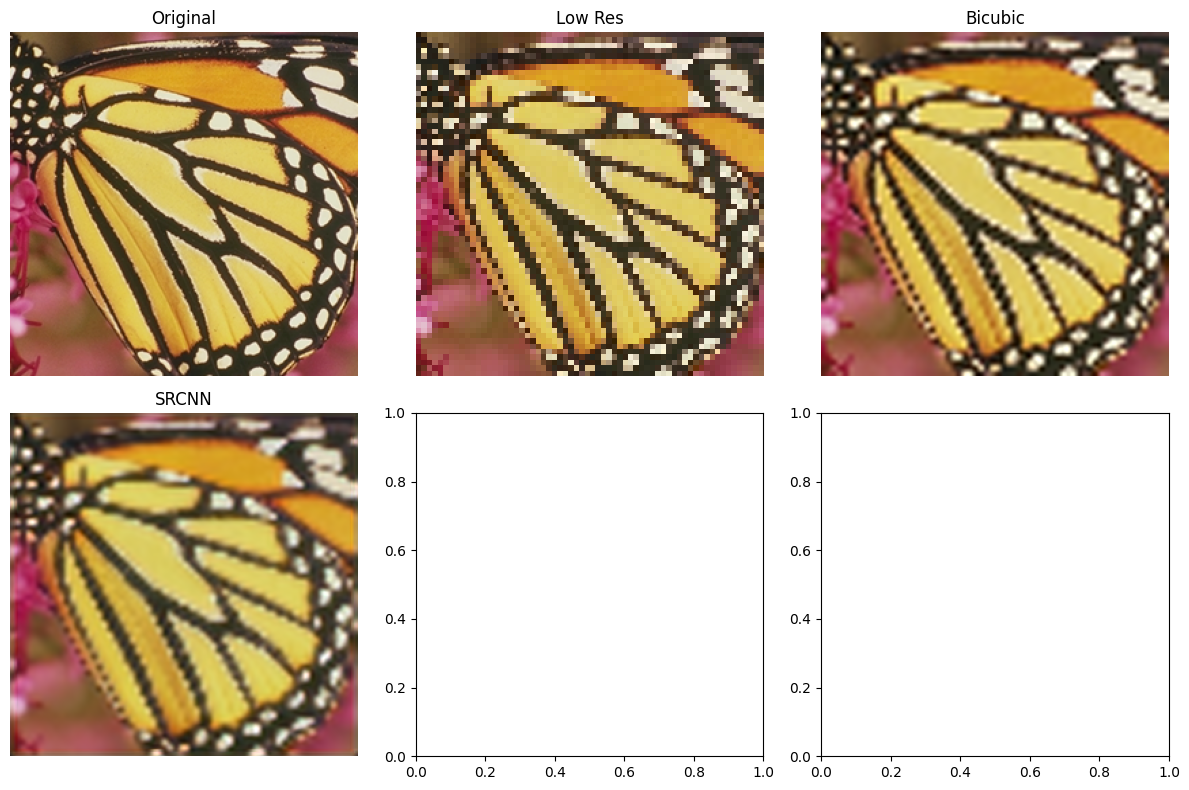

In [27]:
IMAGE_EXAMPLE = "./datasets/Set5/butterfly.png"

from image_helper import ImageHelper
image_helper = ImageHelper()

image_helper.show_tensors_custom_grid(
    tensors = [
        {
            "label": "Original",
            "tensor": image_helper.image_to_tensor(IMAGE_EXAMPLE),
        },
        {
            "label": "Low Res",
            "tensor": image_helper.downsample_image_as_tensor(
                IMAGE_EXAMPLE, 4, interpolation=Image.BICUBIC,
            ),
        },
        {
            "label": "Bicubic",
            "tensor": image_helper.downsample_and_upsample_image_as_tensor(
                IMAGE_EXAMPLE, 4
            ),
        },
        {
            "label": "SRCNN f2=1",
            "tensor": image_helper.apply_model_to_image(
                model_f2_1,
                IMAGE_EXAMPLE,
                4
            )
        },
        {
            "label": "SRCNN f2=5",
            "tensor": image_helper.apply_model_to_image(
                model_f2_5,
                IMAGE_EXAMPLE,
                4
            )
        },
        

        # {
        #     "label": "DBPN",
        #     "tensor": image_helper.apply_model_to_image(
        #         model=dbpn,
        #         image=IMAGE_EXAMPLE,
        #         downsample_factor=4,
        #         should_upsample=False,
        #         unsqueeze=True
        #     )
        # },
        # {
        #     "label": "SRGAN",
        #     "tensor": image_helper.apply_model_to_image(
        #         srgan.to('cpu'),
        #         IMAGE_EXAMPLE,
        #         downsample_factor=4,
        #         should_upsample=False,
        #         unsqueeze=True,
        #         device='cpu'
        #     )
        # },
    ],
    rows=2,
    cols=3
)